In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from matplotlib.patches import Polygon, Circle
from collections import Counter
from scipy.optimize import root
import heapq
from sympy import symbols, solve, Eq

In [37]:
layout = pd.read_json("braila_connections.json", orient="index")

In [38]:
layout.loc["Jonctiune-1414"]

x                           730678.855
y                           421170.761
connections    [207-A, Jonctiune-2186]
Name: Jonctiune-1414, dtype: object

In [39]:
def make_connections(layout):
    connections_array = []
    names_array = []
    for idx, connection in enumerate(layout["connections"]):
        x1, y1 = layout.iloc[idx].x, layout.iloc[idx].y
        for junction in connection:
            if [layout.iloc[idx].name, layout.loc[junction].name] not in names_array and [layout.loc[junction].name, layout.iloc[idx].name] not in names_array:
                x2, y2 = layout.loc[junction].x, layout.loc[junction].y
                connections_array.append([x1, x2, y1, y2])
                names_array.append([layout.iloc[idx].name, layout.loc[junction].name])
    return connections_array, names_array

In [40]:
connections_array, names_array = make_connections(layout)

In [464]:
def prepare_dijkstra_conn(layout):
    connections_dict = {}
    for index, junction in layout.iterrows():
        
        name = junction.name
        connections_dict[name] = {}
        for conn in junction.connections:
            x2, y2 = layout.loc[conn].x, layout.loc[conn].y
            distance = np.sqrt(((junction.x-x2)*11.32)**2 + ((junction.y-y2)*11.32)**2)
            connections_dict[name][conn] = distance
            
    return connections_dict
            

In [465]:
dijkstra_graph = prepare_dijkstra_conn(layout)

In [574]:
def strength_function(x1, x2, y1, y2, current_strength, k):
    distance = np.sqrt(((x2-x1)*11.32)**2 + ((y2-y1)*11.32)**2)
    #distance = distance_deg * 11.32 ## approximate distance in m
    strength = current_strength - distance**0.3
    return strength

In [575]:
def set_point_of_leakage(connections, names):
    n_pipe = random.randint(0, len(connections)-1)
    leakage_pipe = connections[n_pipe]
    leakage_depth = random.random()
    x1, x2, y1, y2 = leakage_pipe
    neigh_a, neigh_b = names[n_pipe]
    x_of_leakage = x1*(1-leakage_depth) + x2*leakage_depth
    y_of_leakage = y1*(1-leakage_depth) + y2*leakage_depth
    return [x_of_leakage, y_of_leakage], [neigh_a, neigh_b]

In [576]:
def set_primary_signal(point_of_leakage, neighbour_junctions, leakage_strength):
    strength_map = {}
    x1, y1 = point_of_leakage
    for junction in neighbour_junctions:
        x2, y2 = layout.loc[junction].x, layout.loc[junction].y
        strength_map[junction] = [x2, y2, strength_function(x1, x2, y1, y2, leakage_strength, 1)]
    return strength_map

In [577]:
def loudness_function(x1, x2, y1, y2, current_strength):
    distance = np.sqrt(((x2-x1)*11.32)**2 + ((y2-y1)*11.32)**2)
    #distance = distance_deg * 11.32 ## approximate distance in m
    strength = current_strength -distance**0.3
    return strength

In [578]:
def set_test_signal(strength_map, layout):
    primary_junction_a, primary_junction_b = strength_map.keys()
    already_set = [[primary_junction_a, [point_of_leakage,
                                        layout.loc[primary_junction_a].connections]],
                   [primary_junction_b, [point_of_leakage,
                                        layout.loc[primary_junction_b].connections]]]
    for junction in already_set:
        #if junction[0] == primary_junction_a or junction[0] == primary_junction_b:
        x1, y1 = strength_map[junction[0]][0], strength_map[junction[0]][1]
        for connection in junction[1][1]:
            if connection not in [x[0] for x in already_set]:
                x2, y2 = layout.loc[connection].x, layout.loc[connection].y
                n_connections = len(junction[1][1]) -1 
                starting_strength = strength_map[junction[0]][-1] ## takes strength of previous junction from strength map
                strength = loudness_function(x1, x2, y1, y2, starting_strength)# + 10*np.log10(1/n_connections)
                if strength < 0: #minimum sensitivity
                    strength = 0
                strength_map[connection] = [x2, y2, strength]
                already_set.append([connection, [junction[0], 
                                              layout.loc[connection].connections]])

In [579]:
def calculate_distances(graph, starting_vertex):
    distances = {vertex: float('infinity') for vertex in graph}
    joints = {vertex: 0 for vertex in graph}
    distances[starting_vertex] = 0
    joints[starting_vertex] = 0
    pq = [(0, starting_vertex, 0)]
    while len(pq) > 0:
        current_distance, current_vertex, current_joint = heapq.heappop(pq)
        #print("CURRENT ", current_vertex)
        # Nodes can get added to the priority queue multiple times. We only
        # process a vertex the first time we remove it from the priority queue.
        if current_distance > distances[current_vertex]:
            continue
        for neighbor, weight in graph[current_vertex].items():
            distance = current_distance + weight
            n_joints = current_joint + 1
            # Only consider this new path if it's better than any path we've
            # already found.
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                joints[neighbor] = n_joints
                heapq.heappush(pq, (distance, neighbor, n_joints))
                
    distances = {key:val for key, val in distances.items() if val != np.inf}
    return distances, joints

In [580]:
def get_trail(graph, starting_vertex):
    distances = {vertex: float('infinity') for vertex in graph}
    trail = {vertex: [starting_vertex] for vertex in graph}
    distances[starting_vertex] = 0
    trail[starting_vertex] = [starting_vertex, 0]
    pq = [(0, starting_vertex, [[starting_vertex, 0]])]
    while len(pq) > 0:
        current_distance, current_vertex, temp = heapq.heappop(pq)
        #print("CURRENT ", current_vertex)
        # Nodes can get added to the priority queue multiple times. We only
        # process a vertex the first time we remove it from the priority queue.
        if current_distance > distances[current_vertex]:
            continue
        for neighbor, weight in graph[current_vertex].items():
            distance = current_distance + weight
            tempo = np.append(temp, [[neighbor, weight]], axis=0)
            # Only consider this new path if it's better than any path we've
            # already found.
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                trail[neighbor] = tempo
                heapq.heappush(pq, (distance, neighbor, tempo))
                
    distances = {key:val for key, val in distances.items() if val != np.inf}
    return trail

In [581]:
dijkstra_map, n_joints = calculate_distances(dijkstra_graph, "SenzorComunarzi-NatVech")

In [582]:
trail = get_trail(dijkstra_graph, "SenzorComunarzi-NatVech")

import time

start = time.time()
for i in range(1000):
    total_junction_fall = np.sum([-10*0.342*np.log10(1/(len(layout.loc[x].connections)-1)) for x in trail["Jonctiune-J-25"][:-1, 0]])
end = time.time()
print(end - start)
start = time.time()
for i in range(1000):
    tot_splits = np.product([len(layout.loc[x].connections)-1 for x in trail["Jonctiune-J-25"][:-1, 0]])
    total_junction_fall_new = -10*0.342*np.log10(1/tot_splits)
end = time.time()
print(end - start)



In [583]:
faulty =[]

In [584]:
def new_strength_map(leakage_strength, layout, connections, names):
    point_of_leakage, neigh = set_point_of_leakage(connections, names)
    strength_map = set_primary_signal(point_of_leakage, neigh, leakage_strength)
    
    for start_junction in neigh:
        start_strength = strength_map[start_junction][-1]
        trail = get_trail(dijkstra_graph, start_junction)
        for endpoint in trail:
            if endpoint == start_junction: continue
            try: ## this is to catch currently isolated junctions
                    #print("EDNOINOAN", endpoint)
                    #print(trail[endpoint])
                total_strength_fall = np.sum([float(x)**0.3 for x in trail[endpoint][:, -1]])
                ## total_junction_fall is fall in strength due to pipe division in junction 
                ## calculated with 10*log10(1/split) 
                total_junction_fall = sum([-10*np.log10(1/(len(layout.loc[x].connections)-1)) for x in trail[endpoint][:-1, 0] if len(layout.loc[x].connections)-1 != 0])
                #total_junction_fall = -10*np.log10(1/total_splits)
                total_strength = start_strength - total_strength_fall - total_junction_fall
                if total_strength < 0: total_strength = 0
                if endpoint in strength_map.keys() and total_strength > strength_map[endpoint][-1]:
                    x, y = layout.loc[endpoint].x, layout.loc[endpoint].y
                    strength_map[endpoint] = [x, y, total_strength]
                elif endpoint not in strength_map.keys():
                    x, y = layout.loc[endpoint].x, layout.loc[endpoint].y
                    strength_map[endpoint] = [x, y, total_strength]
            except TypeError as e:
                if endpoint not in faulty:
                    faulty.append(endpoint)
                    print(endpoint, trail[endpoint])
    return strength_map, point_of_leakage

In [585]:
#test_map = new_strength_map(100, layout, connections_array, names_array)

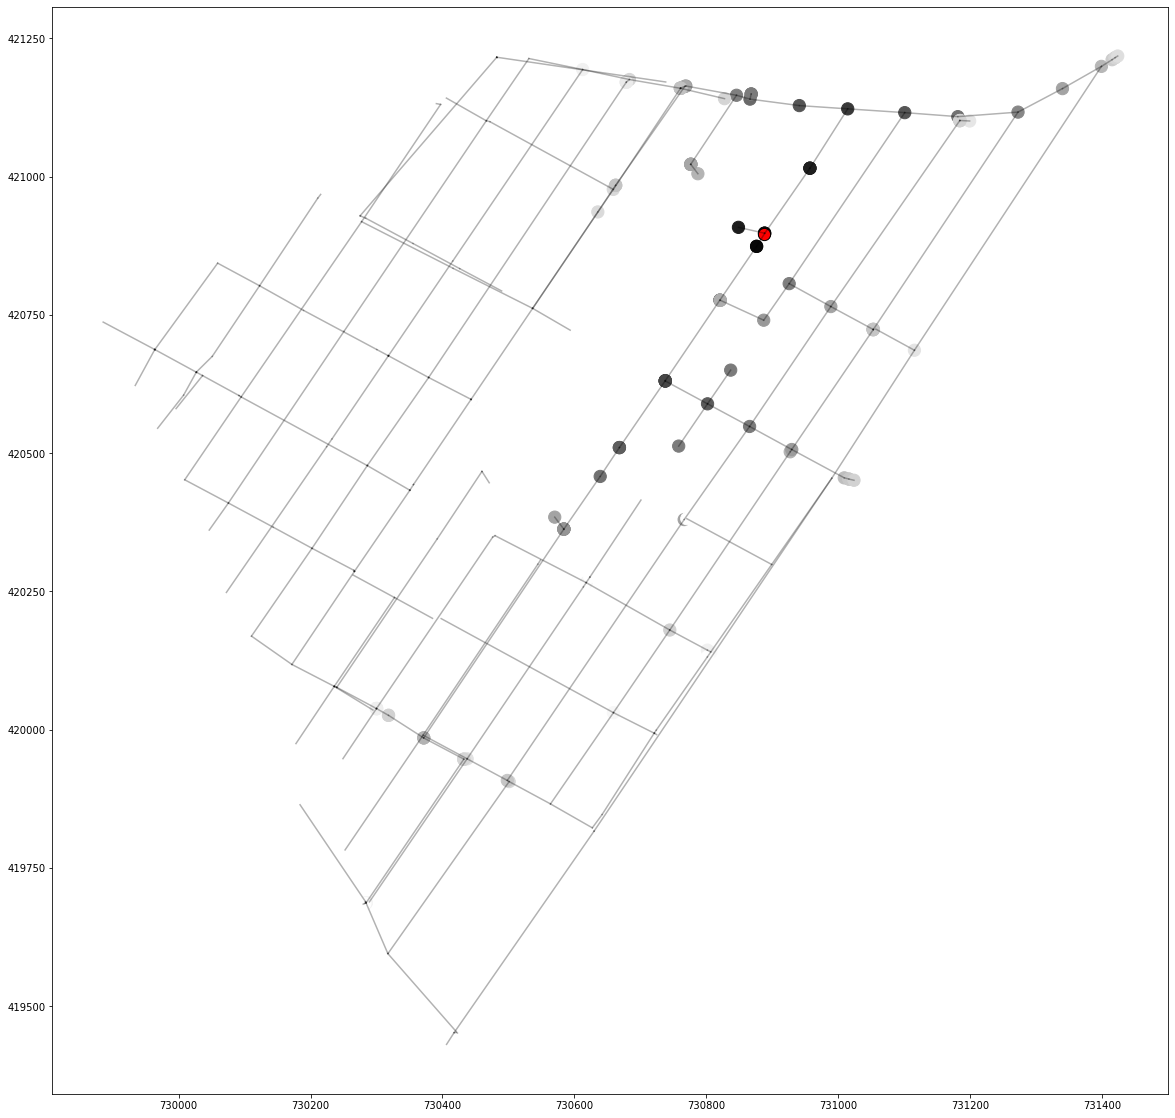

In [783]:
strength_map, point_of_leakage = new_strength_map(100, layout, connections_array, names_array)
strength_map = pd.DataFrame(strength_map.values(), index=strength_map.keys(),columns=["x", "y", "strength"])
plt.figure(figsize=(20, 20))
plt.scatter(strength_map.x, strength_map.y, c=strength_map.strength, s=150, cmap="gray_r")
for connection in connections_array:
    plt.plot(connection[:2], connection[2:4], "k-", alpha=0.3)
plt.scatter(point_of_leakage[0], point_of_leakage[1], s=150, c="red", edgecolors="k")

In [784]:
def create_multi(strength_map, point_of_leakage):
    strength_map_second, point_of_leakage_second = new_strength_map(50, layout, connections_array, names_array)
    strength_map_second = pd.DataFrame(strength_map_second.values(), index=strength_map_second.keys(),columns=["x", "y", "strength"])
    leakages = [point_of_leakage, point_of_leakage_second]
    sm_multi = strength_map.add(strength_map_second[["strength"]], fill_value=0)
    plt.figure(figsize=(20, 20))
    plt.scatter(sm_multi.x, sm_multi.y, c=sm_multi.strength, s=150, cmap="gray_r")
    for connection in connections_array:
        plt.plot(connection[:2], connection[2:4], "k-", alpha=0.3)
    plt.scatter(point_of_leakage[0], point_of_leakage[1], s=150, c="red", edgecolors="k")
    plt.scatter(point_of_leakage_second[0], point_of_leakage_second[1], s=150, c="red", edgecolors="k")
    return sm_multi[["x", "y", "strength"]], leakages

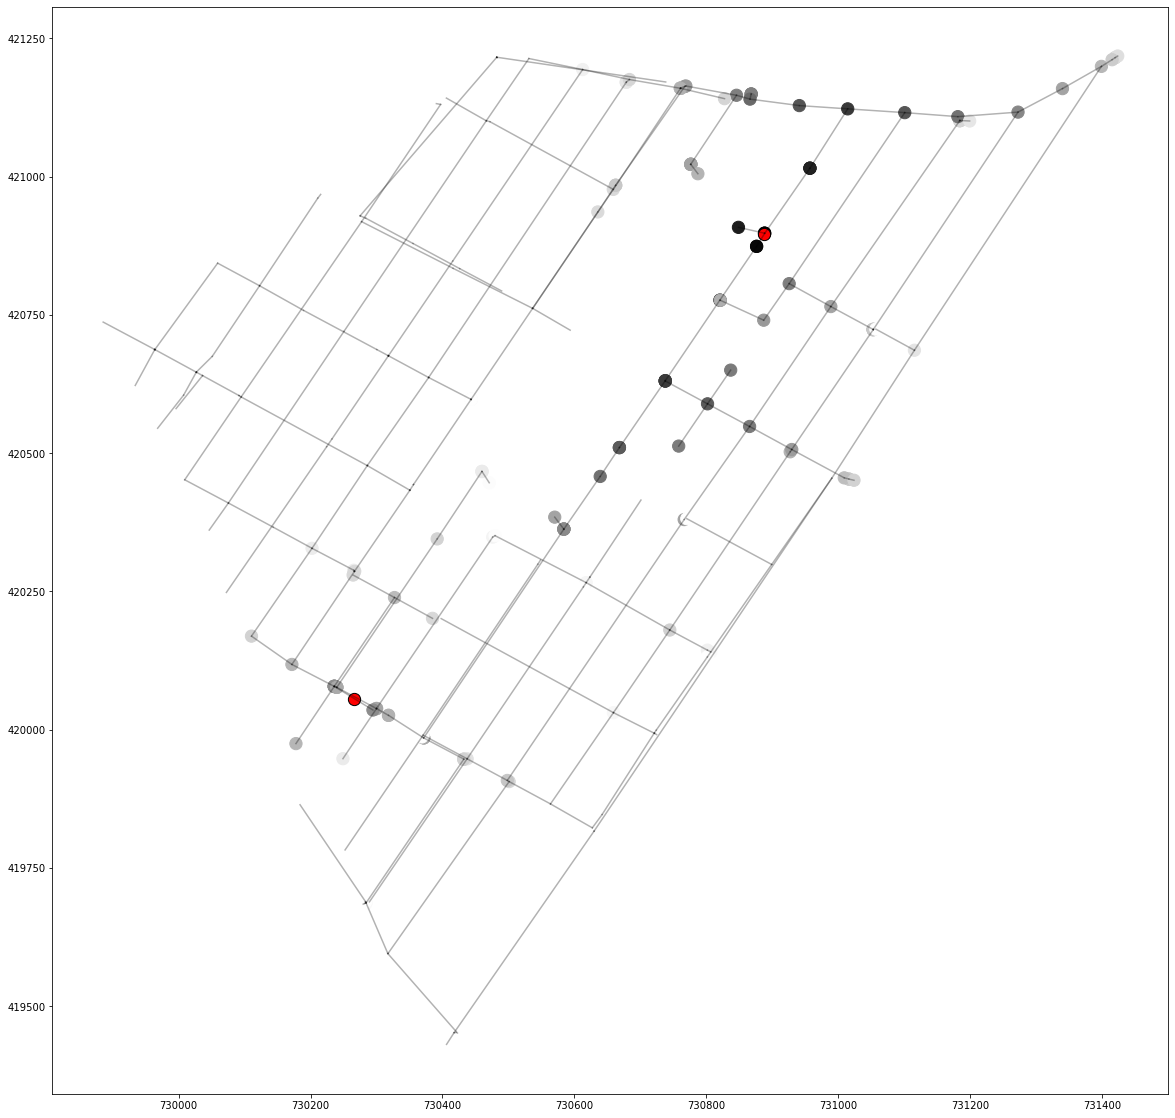

In [785]:
strength_map, leakages = create_multi(strength_map, point_of_leakage)

In [768]:
strength_map.loc["Jonctiune-1415"]

x           730379.000476
y           420636.598294
strength        13.045310
Name: Jonctiune-1415, dtype: float64

In [769]:
strength_map_second.max()

x           731424.043556
y           421217.866955
strength        79.333447
dtype: float64

In [770]:
sensors = np.array([strength_map.loc[sensor].values for sensor in strength_map.index if "Senzor" in sensor])

In [771]:
sensors

array([[7.30318013e+05, 4.20675896e+05, 2.68649754e+01],
       [7.30744713e+05, 4.20180045e+05, 0.00000000e+00],
       [7.30761029e+05, 4.21159518e+05, 0.00000000e+00],
       [7.30171623e+05, 4.20117800e+05, 4.12672184e+01]])

In [772]:
sensor = "SenzorComunarzi-castanului"

In [791]:
init_param = {
    "source_strength": 50,
    "fall_exp": 0.03,
    "junction_division": "equal",
    "tolerance": 0.1,
    "predicted_actual_error": 0.1,
    "starting_sensors" : ["SenzorComunarzi-castanului", "SenzorComunarzi-NatVech", "SenzorChisinau-Titulescu", "SenzorCernauti-Sebesului"],
    "avg_division":1
}

In [792]:
def distance_approximator(strength, strength_fall, name_of_sensor, dijkstra_map, n_junctions, error_tolerance):
    approx_start = time.time()
    possible_leak_neigh = []
    check_trail = get_trail(dijkstra_graph, name_of_sensor)
    for junction, distance in dijkstra_map.items():
        if distance != 0:
            hypothetical_fall = sum([float(x)**init_param["fall_exp"] for x in check_trail[junction][:, -1]])
            if hypothetical_fall <= strength_fall:
                #avg_division = init_param["avg_division"]
                total_splits = np.product([len(layout.loc[x].connections)-1 for x in check_trail[junction][1:, 0] if len(layout.loc[x].connections) != 1]) 
                total_junction_fall = -10*np.log10(1/total_splits)
                error = strength_fall - hypothetical_fall -total_junction_fall#- junction_fall - hypothetical_fall # comparing actual fall in strength with fall due to distance and pipe division
                #print("ERRORR: ", error)
                if abs(error) < error_tolerance:
                    possible_leak_neigh.append(junction)
    approx_stop = time.time()
    print("Approximation time: ", approx_stop-approx_start)
    return possible_leak_neigh

In [793]:
def calibrate(sensors, possible_junctions, randomize):
    calib_start = time.time()
    if randomize:
        idx = random.randint(0, len(list(layout.index))-1)
        check_junction = list(layout.index)[idx]
    else: 
        check_junction = possible_junctions[0]
    total_dist_err = 0
    total_junctions = 0
    total_strength = 0
    change_exp = []
    if check_junction in init_param["starting_sensors"]: 
            raise SystemExit("Leakage found at ", check_junction) ### IN THE FUTURE, CHANGE RAISE TO stop = True to break out of loop
    for sensor in init_param["starting_sensors"]:
        if strength_map.loc[sensor].strength == 0: continue ##checks whether a sensor is getting any signal at all
        dijkstra_map, n_joints = calculate_distances(dijkstra_graph, sensor)
        trail = get_trail(dijkstra_graph, sensor)
        actual_strength = strength_map.loc[check_junction].strength ### strength of newly checked sensor
        sensor_strength = strength_map.loc[sensor].strength ### strength of starting sensor
        ## calculating fall due to pipe splits
        total_splits = np.product([len(layout.loc[x].connections)-1 for x in trail[check_junction][1:, 0] if len(layout.loc[x].connections) != 1])
        total_junction_fall = -10*np.log10(1/total_splits)
        predicted_strength = sensor_strength + sum([float(x)**init_param["fall_exp"] for x in trail[check_junction][:, -1]]) + total_junction_fall
        print("PREDICTED", predicted_strength)
        print("ACTUAL: ", actual_strength)
        total_dist_err += predicted_strength - actual_strength
    ###################################### DISTANCE LOSS CORRECTION ##############################################
        true_fall = abs(actual_strength - sensor_strength)
        new_exp = 0
        print(true_fall, total_junction_fall)
        def exp_fall_eq(x):
            func = sum([float(el)**x for el in trail[check_junction][:, -1]])
            func = func - true_fall + total_junction_fall
            return func
        new_exp_solve = root(exp_fall_eq, 1, tol=1e-10)
        print("Solved", new_exp_solve.success)
        new_exp = new_exp_solve.x
        
        #while True:
        #    fall = sum([float(x)**new_exp for x in trail[check_junction][:, -1]])
        #    if new_exp > 2:
        #            new_exp = init_param["fall_exp"]
        #            print("couldnt doit")
        #            break
        #    if abs(true_fall - fall - total_junction_fall) < 0.001: #change for speed
        #        break
        #    new_exp += 0.00001
        #print(new_exp)
        change_exp.append(new_exp * sensor_strength)
        total_strength += sensor_strength
    param_exp_change = sum(change_exp)/total_strength
    print("CHANGE FALL EXP TO ", param_exp_change) 
    calib_stop = time.time()
    print("Calibration time: ", calib_stop-calib_start)
    return param_exp_change
   

In [794]:
def locate(sensors):
    locate_start = time.time()
    print("USING: ", init_param)
    agreed = []
    error_tolerance = init_param["predicted_actual_error"]
    n = 1
    while agreed == []:
        predictions = np.array([])
        for sensor in init_param["starting_sensors"]:
            sensor = strength_map.loc[sensor].values
            possible_junctions = []
            tolerance = init_param["tolerance"]
            strength_of_sensor = sensor[-1]
            name_of_sensor = strength_map.loc[strength_map["x"] == sensor[0]].index[0]
            strength_fall = init_param["source_strength"] - strength_of_sensor
            dijkstra_map, n_junctions = calculate_distances(dijkstra_graph, name_of_sensor)
            possible_junctions = distance_approximator(strength_of_sensor, strength_fall, name_of_sensor, dijkstra_map, n_junctions, error_tolerance)
            #if error_tolerance > 200: print("SENSOR :, ", sensor, possible_junctions)
            predictions = np.append(predictions,  [possible_junctions])
        agreed = [item for item, count in Counter(predictions).items() if count > len(init_param["starting_sensors"])-n]
        
        if error_tolerance > 200:
            n += 1
            error_tolerance = init_param["predicted_actual_error"]
        elif error_tolerance > 100: 
            error_tolerance += 50
        elif error_tolerance > 10:
            error_tolerance += 10
        else:
            error_tolerance += 1
        print("/////////////////////////////////////////////////////////////////////////////////////////////////n", error_tolerance)
    print("n_sensors used: ", len(init_param["starting_sensors"])-n+1, "/", len(init_param["starting_sensors"]))   
    locate_stop = time.time()
    print("Location search time: ", locate_stop-locate_start)
    return predictions, agreed
    

USING:  {'source_strength': 50, 'fall_exp': 0.03, 'junction_division': 'equal', 'tolerance': 0.1, 'predicted_actual_error': 0.1, 'starting_sensors': ['SenzorComunarzi-castanului', 'SenzorComunarzi-NatVech', 'SenzorChisinau-Titulescu', 'SenzorCernauti-Sebesului'], 'avg_division': 1}
Approximation time:  0.8349871635437012
Approximation time:  0.5239999294281006
Approximation time:  0.9119997024536133
Approximation time:  1.0489997863769531
/////////////////////////////////////////////////////////////////////////////////////////////////n 1.1
Approximation time:  0.8299996852874756
Approximation time:  0.5239996910095215
Approximation time:  0.9119997024536133
Approximation time:  1.0489997863769531
/////////////////////////////////////////////////////////////////////////////////////////////////n 2.1
Approximation time:  0.8299996852874756
Approximation time:  0.5240006446838379
Approximation time:  0.9129998683929443
Approximation time:  1.0490002632141113
///////////////////////////////

<ipython-input-793-16294965cece>:32: RuntimeWarning: divide by zero encountered in power
  func = sum([float(el)**x for el in trail[check_junction][:, -1]])


PREDICTED [108.06056308]
ACTUAL:  33.4879895659929
3.588402703889713 21.072099696478684
Solved False
PREDICTED [54.94309664]
ACTUAL:  33.4879895659929
15.837334002705894 12.552725051033061
Solved False
PREDICTED [145.39395681]
ACTUAL:  33.4879895659929
52.55151955362337 16.812412373755873
Solved True
CHANGE FALL EXP TO  [0.11166525]
Calibration time:  0.053999900817871094
newly selected append sensor:  249-A
USING:  {'source_strength': 50, 'fall_exp': array([0.11166525]), 'junction_division': 'equal', 'tolerance': 0.1, 'predicted_actual_error': 0.1, 'starting_sensors': array(['SenzorComunarzi-castanului', 'SenzorComunarzi-NatVech',
       'SenzorChisinau-Titulescu', 'SenzorCernauti-Sebesului',
       'Jonctiune-1635', '249-A'], dtype='<U26'), 'avg_division': 1}
Approximation time:  0.40400004386901855
Approximation time:  0.24100017547607422
Approximation time:  0.5230000019073486
Approximation time:  1.065999984741211
Approximation time:  0.026000022888183594
Approximation time:  0.19

<ipython-input-793-16294965cece>:32: RuntimeWarning: divide by zero encountered in power
  func = sum([float(el)**x for el in trail[check_junction][:, -1]])


Solved False
PREDICTED [150.79650833]
ACTUAL:  0.0
86.03950911961627 30.614524790871933
Solved True
PREDICTED [58.60379334]
ACTUAL:  0.0
33.4879895659929 13.802112417116062
Solved True
CHANGE FALL EXP TO  [0.17417571]
Calibration time:  0.06200075149536133
newly selected append sensor:  Jonctiune-2182
USING:  {'source_strength': 50, 'fall_exp': array([0.17417571]), 'junction_division': 'equal', 'tolerance': 0.1, 'predicted_actual_error': 0.1, 'starting_sensors': array(['SenzorComunarzi-castanului', 'SenzorComunarzi-NatVech',
       'SenzorChisinau-Titulescu', 'SenzorCernauti-Sebesului',
       'Jonctiune-1635', '249-A', 'Jonctiune-2182'], dtype='<U26'), 'avg_division': 1}
Approximation time:  0.17099928855895996
Approximation time:  0.12299990653991699
Approximation time:  0.315000057220459
Approximation time:  0.6970000267028809
Approximation time:  0.02499985694885254
Approximation time:  0.09000039100646973
Approximation time:  0.7379999160766602
////////////////////////////////////

<ipython-input-793-16294965cece>:32: RuntimeWarning: divide by zero encountered in power
  func = sum([float(el)**x for el in trail[check_junction][:, -1]])


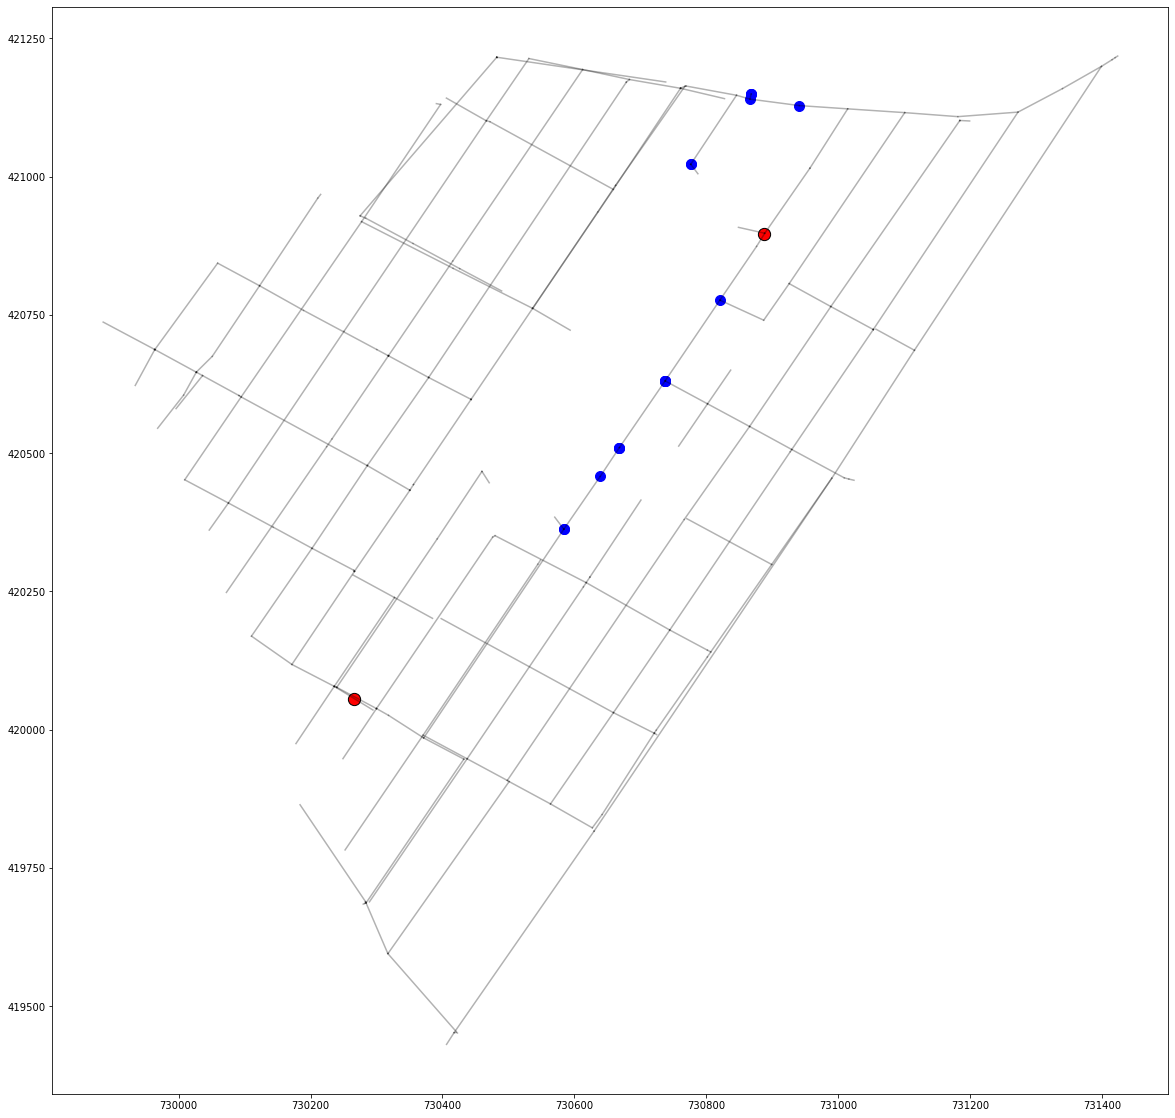

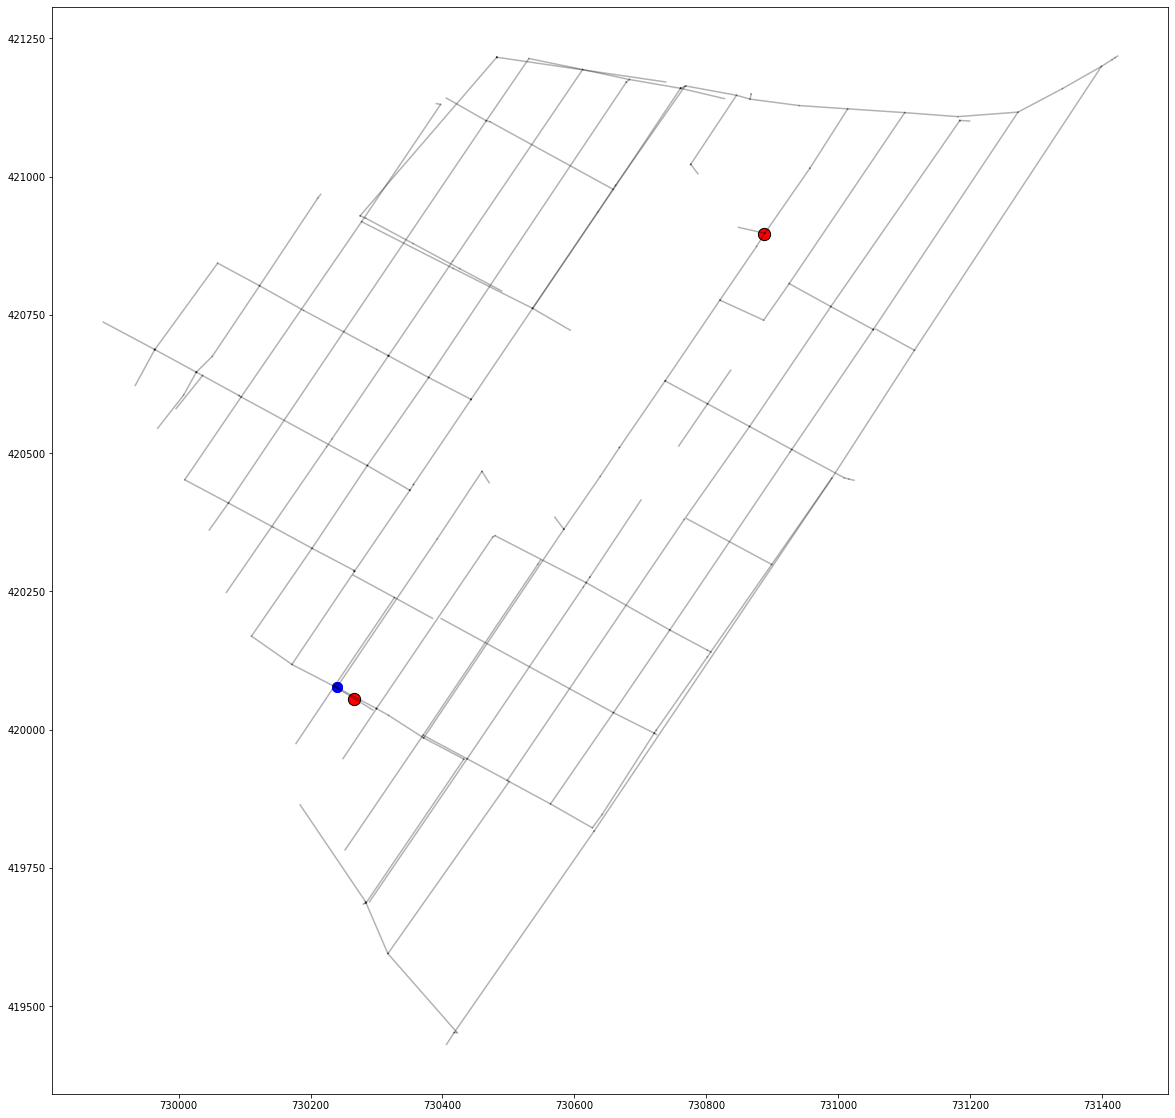

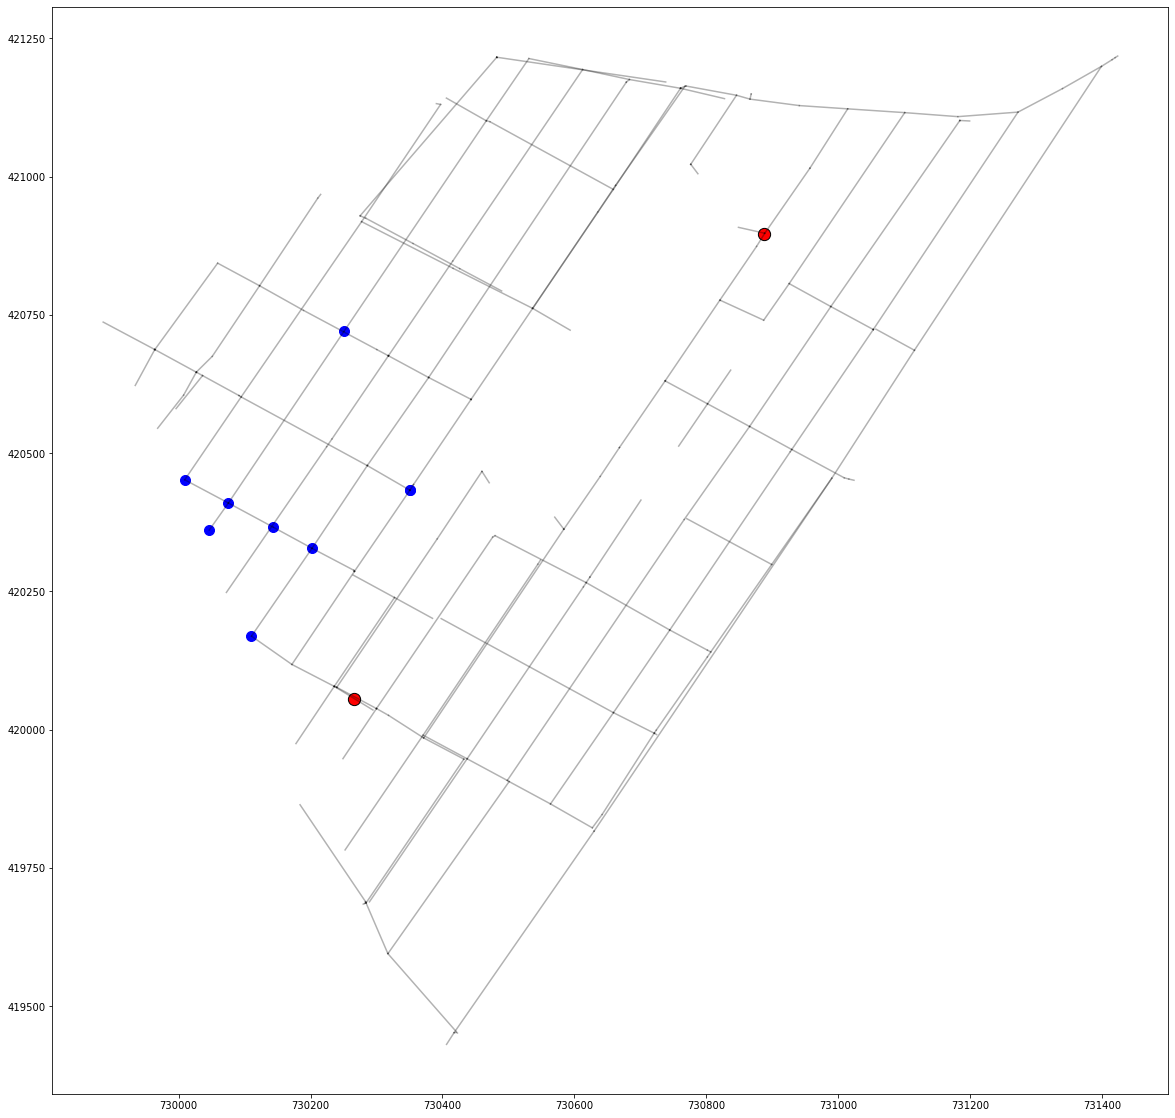

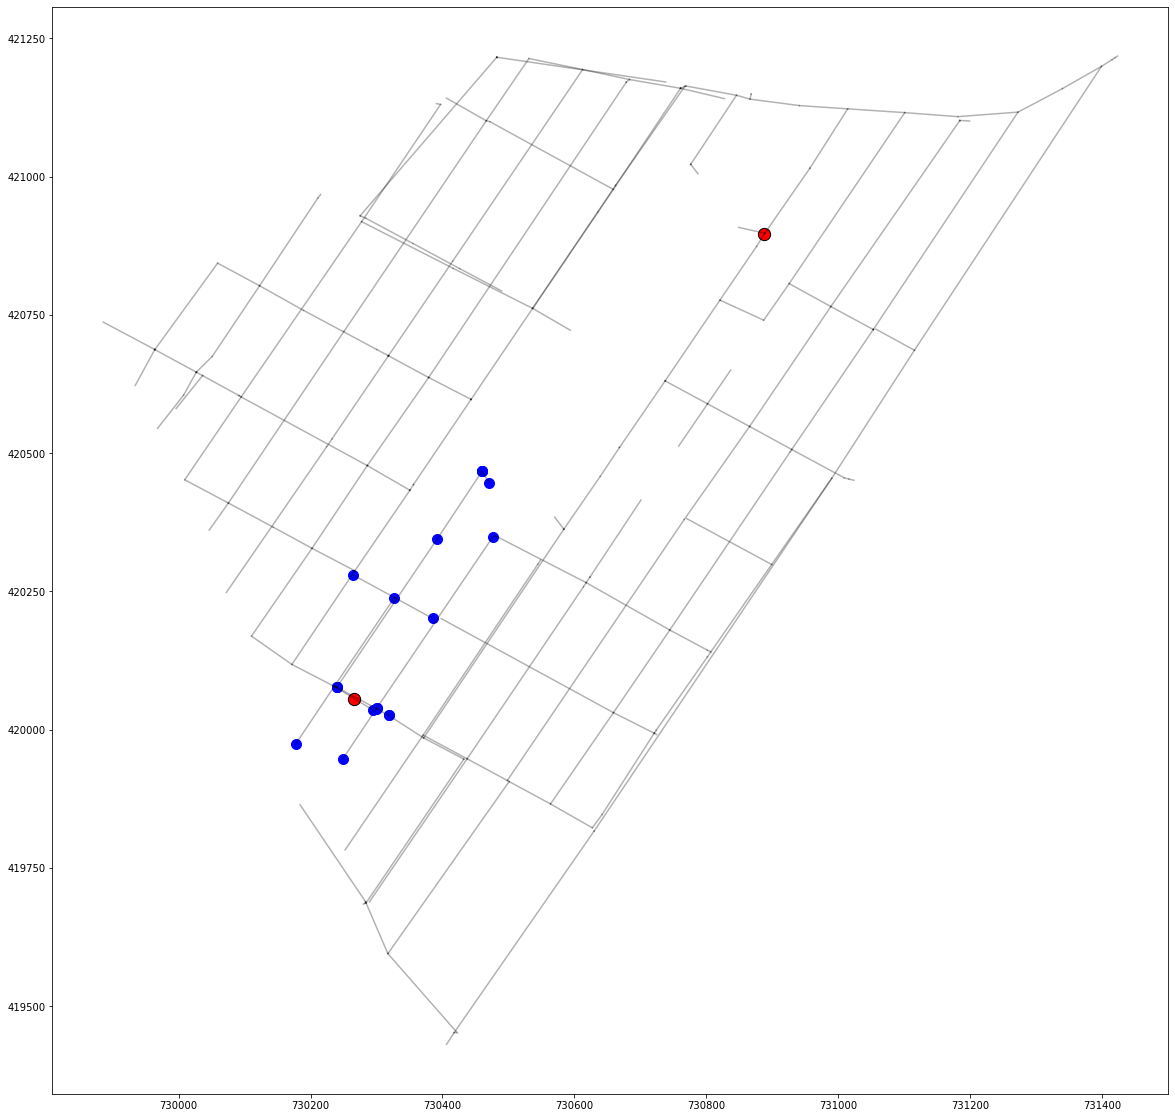

In [795]:
for i in range(4):
    possible_junctions, agreed = locate(sensors)
    plt.figure(figsize=(20, 20))
    #plt.scatter(strength_map.x, strength_map.y, c=strength_map.strength, s=150, cmap="gray_r")
    for connection in connections_array:
        plt.plot(connection[:2], connection[2:4], "k-", alpha=0.3)
    for point_of_leakage in leakages:
        plt.scatter(point_of_leakage[0], point_of_leakage[1], s=150, c="red", edgecolors="k")
    #for junction in possible_junctions:
        #plt.scatter(layout.loc[junction].x, layout.loc[junction].y, s=100, c="orange")
    for junction in agreed:
        plt.scatter(layout.loc[junction].x, layout.loc[junction].y, s=100, c="blue")
    new_fall_exp = calibrate(sensors, agreed, randomize=False)
    
    new_sensor = list(agreed)[0]
    strength_map.loc[agreed]
    print("newly selected append sensor: ", new_sensor)
    init_param["starting_sensors"] = np.append(init_param["starting_sensors"], [new_sensor])
    init_param["fall_exp"] = new_fall_exp

In [365]:
def exp_fall_eq(x):
    print("X", x)
    func = sum([float(el)**x for el in trail["PT2"][:, -1]])
    print("FALL", func)
    func = func - 100 + 30
    print(func)
    return func
new_exp = root(exp_fall_eq, 0, tol=1e-10)
print(new_exp)

X [0]
FALL [11.]
[-59.]
X [0.]
FALL [11.]
[-59.]
X [0.]
FALL [11.]
[-59.]
X [1.49011612e-08]
FALL [7.00000042]
[-62.99999958]
X [-2.19792151e-07]
FALL [inf]
[inf]
X [0.]
FALL [11.]
[-59.]
    fjac: array([[-1.]])
     fun: array([-59.])
 message: 'The solution converged.'
    nfev: 4
     qtf: array([59.])
       r: array([inf])
  status: 1
 success: True
       x: array([0.])


<ipython-input-365-e6b9919d4660>:3: RuntimeWarning: divide by zero encountered in power
  func = sum([float(el)**x for el in trail["PT2"][:, -1]])
